## Part Zero: Import Statments and Data

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import r2_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import  precision_score, recall_score, roc_auc_score, cohen_kappa_score
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Part One: Fitting Models

In [3]:
pt1_X = ha.drop("output", axis=1)
pt1_y = ha["output"]

X_train, X_test, y_train, y_test = train_test_split(
    pt1_X, pt1_y, test_size=0.3, random_state=42)

In [4]:
ct = ColumnTransformer(
    [("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output = False)
    , make_column_selector(dtype_exclude=np.number)),  
    ], 
    remainder = "drop" 

).set_output(transform = "pandas" ,)

### Q1: KNN

In [5]:
knn_pipe = Pipeline([
    ("preprocess", ct),
    ("KNN", KNeighborsClassifier())
]).set_output(transform="pandas")

In [6]:
param_grid_knn = {
    "KNN__n_neighbors": range(1,100),
    "KNN__weights": ["uniform", "distance"],  # optional but often helpful
    "KNN__p": [1, 2],                         # 1=Manhattan, 2=Euclidean
}

In [7]:
knn_gs = GridSearchCV(knn_pipe, param_grid_knn, cv=5, scoring = "roc_auc", n_jobs = -1)

test_fit_knn = knn_gs.fit(X_train, y_train)

In [8]:
print("After tuning for the model the best parameters that will be used for the final knn model are:"
+"\n" + str(test_fit_knn.best_params_))
print("The Cross Validated AUC ROC Score for that model was"
"\n" + str(test_fit_knn.best_score_))

After tuning for the model the best parameters that will be used for the final knn model are:
{'KNN__n_neighbors': 92, 'KNN__p': 1, 'KNN__weights': 'distance'}
The Cross Validated AUC ROC Score for that model was
0.8928654970760233


In [9]:
Final_KNN_Pipe = Pipeline([
    ("preprocess", ct),
    ("KNN", KNeighborsClassifier(n_neighbors = 92,
                                 p = 1,
                                 weights = "distance"))
]).set_output(transform="pandas")

Fit_Final_KNN = Final_KNN_Pipe.fit(X_train, y_train)

pred_final_KNN = Fit_Final_KNN.predict(X_test)

print("K=92 neighbors  accuracy:",  accuracy_score(y_test, pred_final_KNN))
print(classification_report(y_test, pred_final_KNN))

K=92 neighbors  accuracy: 0.7317073170731707
              precision    recall  f1-score   support

           0       0.65      0.83      0.73        36
           1       0.83      0.65      0.73        46

    accuracy                           0.73        82
   macro avg       0.74      0.74      0.73        82
weighted avg       0.75      0.73      0.73        82



In [10]:
labels_KNN = np.unique(np.concatenate([y_test, pred_final_KNN]))

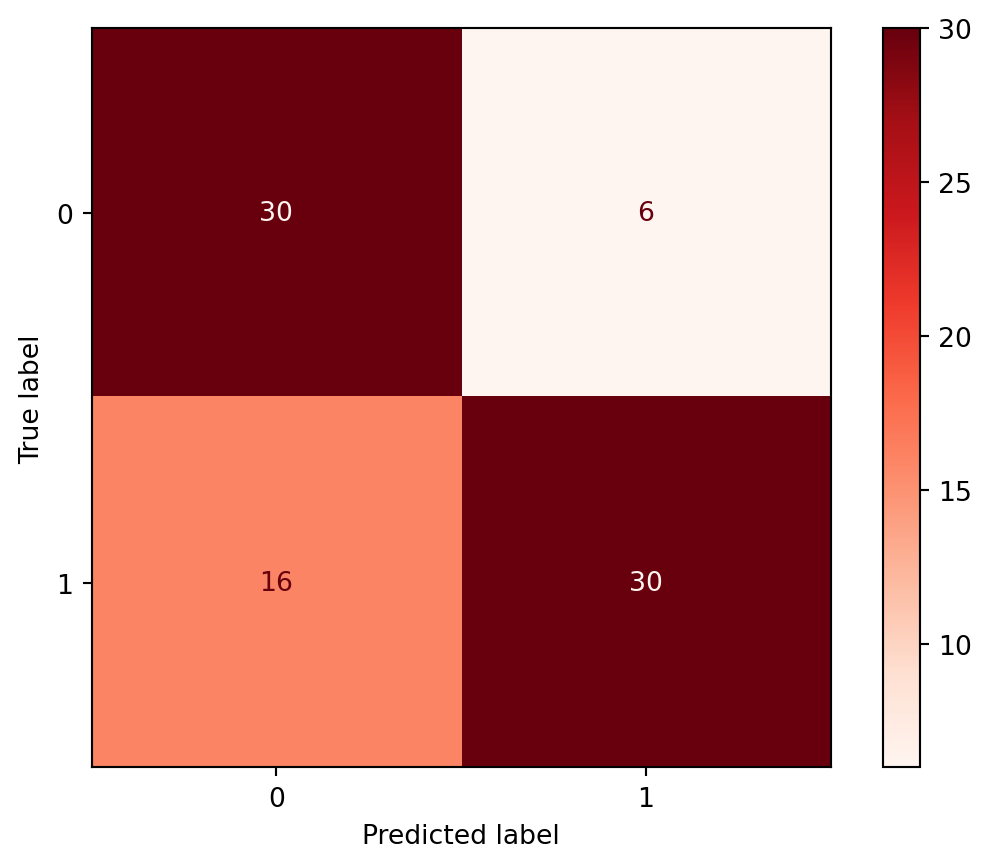

In [11]:
cm_knn = confusion_matrix(y_test, pred_final_KNN, labels=labels_KNN)

cm_knn_df = pd.DataFrame(cm_knn, index=pd.Index(labels_KNN, name="true"),
                         columns=pd.Index(labels_KNN, name="pred"))

ConfusionMatrixDisplay(cm_knn).plot(cmap="Reds",  values_format="d")

### Q2: Logistic Regression

In [12]:
log_pipe = Pipeline([
    ("preprocess", ct),
    ("Log", LogisticRegression())
]).set_output(transform="pandas")

In [13]:
param_grid_log = {"Log__C": [0.01, 0.1, 1, 10, 100],
              "Log__solver": ["lbfgs"],
              "Log__penalty": ["l2"],
              "Log__max_iter": [1000]}

In [14]:
log_gs = GridSearchCV(log_pipe, param_grid_log, cv=5, scoring = "roc_auc", n_jobs = -1)

test_fit_log = log_gs.fit(X_train, y_train)

In [15]:
print("After tuning for the model the best parameters that will be used for the final Logistic model are:"
+"\n" + str(test_fit_log.best_params_))
print("The Cross Validated AUC ROC Score for that model was"
"\n" + str(test_fit_log.best_score_))

After tuning for the model the best parameters that will be used for the final Logistic model are:
{'Log__C': 0.1, 'Log__max_iter': 1000, 'Log__penalty': 'l2', 'Log__solver': 'lbfgs'}
The Cross Validated AUC ROC Score for that model was
0.8955263157894737


In [16]:
log_final_pipe = Pipeline([
    ("preprocess", ct),
    ("Log", LogisticRegression(C=0.1, max_iter=1000, penalty="l2", solver="lbfgs"))
]).set_output(transform="pandas")

Fit_Final_log = log_final_pipe.fit(X_train, y_train)

pred_final_log = Fit_Final_log.predict(X_test)

print("c=0.1 accuracy:",  accuracy_score(y_test, pred_final_log))
print(classification_report(y_test, pred_final_log))

c=0.1 accuracy: 0.6707317073170732
              precision    recall  f1-score   support

           0       0.60      0.72      0.66        36
           1       0.74      0.63      0.68        46

    accuracy                           0.67        82
   macro avg       0.67      0.68      0.67        82
weighted avg       0.68      0.67      0.67        82



In [17]:
labels_log = np.unique(np.concatenate([y_test, pred_final_log]))

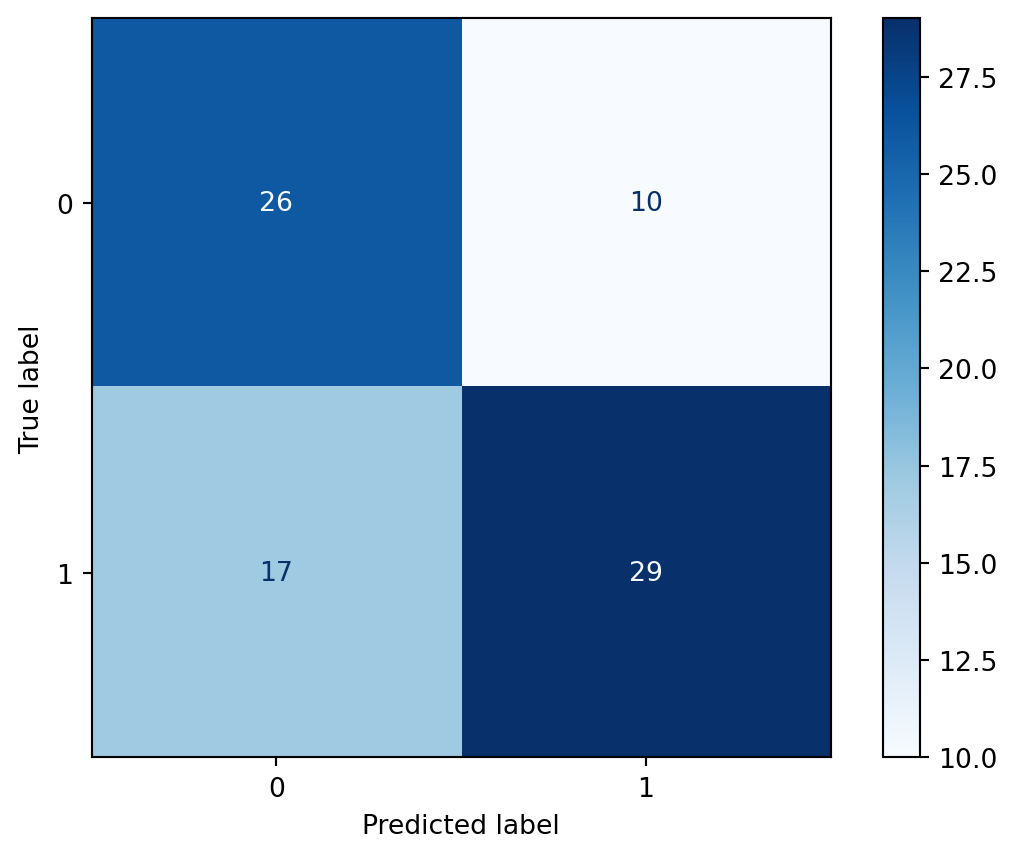

In [18]:
cm_log = confusion_matrix(y_test, pred_final_log, labels=labels_log)

cm_log_df = pd.DataFrame(cm_log, index=pd.Index(labels_log, name="true"),
                         columns=pd.Index(labels_log, name="pred"))

ConfusionMatrixDisplay(cm_log).plot(cmap="Blues",  values_format="d")

### Q3: Descision Tree

In [19]:
Tree_pipeline = Pipeline ([
    ("preprocess", ct),
    ("tree", DecisionTreeClassifier())
]).set_output(transform="pandas")

In [20]:
param_grid_tree = {
    "tree__max_depth": [None, 3, 5, 8, 12],
    "tree__min_samples_split": [2, 5, 10, 20],
    "tree__min_samples_leaf": [1, 2, 5, 10],
    "tree__splitter": ["best", "random"],
    "tree__ccp_alpha": [0.0, 0.0005, 0.001, 0.005]  
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
tree_gs = GridSearchCV(Tree_pipeline, param_grid_tree, cv=cv, scoring = "roc_auc", n_jobs = -1)

test_fit_tree = tree_gs.fit(X_train, y_train)

In [22]:
print("After tuning for the model the best parameters that will be used for the final tree model are:"
+"\n" + str(test_fit_tree.best_params_))
print("The Cross Validated AUC ROC Score for that model was"
"\n" + str(test_fit_tree.best_score_))

After tuning for the model the best parameters that will be used for the final tree model are:
{'tree__ccp_alpha': 0.001, 'tree__max_depth': 5, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 20, 'tree__splitter': 'random'}
The Cross Validated AUC ROC Score for that model was
0.8649545884835929


In [23]:
Final_tree_pipe = Pipeline([
    ("preprocess", ct),
    ("tree", DecisionTreeClassifier(ccp_alpha=0.005, max_depth=8, min_samples_leaf=1,
                                    min_samples_split=10, splitter="random"))
]).set_output(transform="pandas")

Fit_Final_tree = Final_tree_pipe.fit(X_train, y_train)

pred_final_tree = Fit_Final_tree.predict(X_test)

print("tree model accuracy:",  accuracy_score(y_test, pred_final_tree))
print(classification_report(y_test, pred_final_tree))

tree model accuracy: 0.7073170731707317
              precision    recall  f1-score   support

           0       0.63      0.81      0.71        36
           1       0.81      0.63      0.71        46

    accuracy                           0.71        82
   macro avg       0.72      0.72      0.71        82
weighted avg       0.73      0.71      0.71        82



In [24]:
labels_tree = np.unique(np.concatenate([y_test, pred_final_tree]))

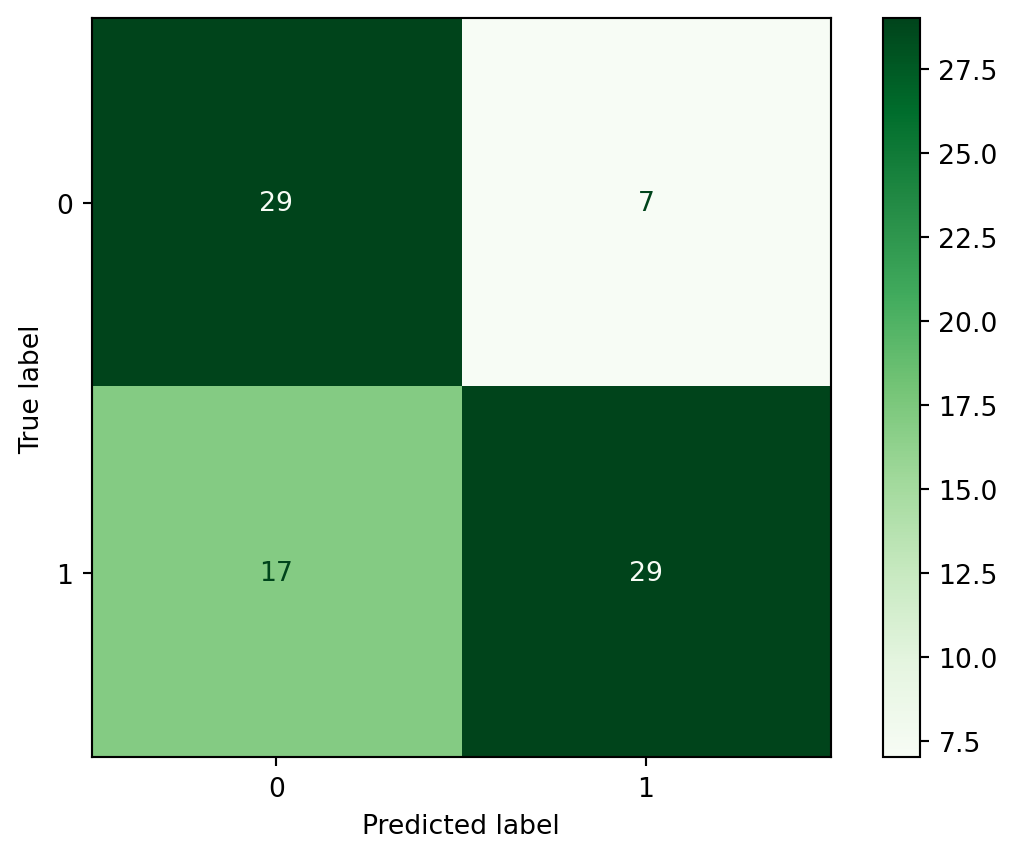

In [25]:
cm_tree = confusion_matrix(y_test, pred_final_tree, labels=labels_tree)

cm_tree_df = pd.DataFrame(cm_tree, index=pd.Index(labels_tree, name="true"),
                         columns=pd.Index(labels_tree, name="pred"))

ConfusionMatrixDisplay(cm_tree).plot(cmap="Greens",  values_format="d")

### Q4: Interpretation

In [26]:
KNN_feat = Fit_Final_KNN.named_steps["preprocess"].get_feature_names_out()

r = permutation_importance(Fit_Final_KNN, X_test, y_test,
                           scoring="accuracy", n_repeats=20,
                           random_state=42, n_jobs=-1)

KNN_df = pd.DataFrame({"feature_out": KNN_feat,
                        "importance": r.importances_mean
                        })

KNN_df["model"] = "KNN"
KNN_df

,feature_out,importance,model
0,num__age,0.039024,KNN
1,num__sex,0.039024,KNN
2,num__cp,0.086585,KNN
3,num__trtbps,-0.004878,KNN
4,num__chol,0.018293,KNN
5,num__restecg,0.037805,KNN
6,num__thalach,0.035366,KNN


In [27]:
feat_log = Fit_Final_log.named_steps["preprocess"].get_feature_names_out()
log_coef = Fit_Final_log.named_steps["Log"].coef_
log_coef_abs = (abs(log_coef).mean(axis=0) if log_coef.ndim == 2 else abs(log_coef))

lr_df = pd.DataFrame({"feature_out": feat_log, "importance": log_coef_abs})
lr_df["model"] = "Logistic Regression"
lr_df

,feature_out,importance,model
0,num__age,0.192267,Logistic Regression
1,num__sex,0.718864,Logistic Regression
2,num__cp,0.640780,Logistic Regression
3,num__trtbps,0.184303,Logistic Regression
4,num__chol,0.181230,Logistic Regression
5,num__restecg,0.006380,Logistic Regression
6,num__thalach,0.834567,Logistic Regression


In [28]:
feat_tree = Fit_Final_tree.named_steps["preprocess"].get_feature_names_out()
imp_tree  = Fit_Final_tree.named_steps["tree"].feature_importances_

tree_df = pd.DataFrame({"feature_out": feat_tree, "importance": imp_tree})
tree_df["model"] = "Tree"
tree_df

,feature_out,importance,model
0,num__age,0.120341,Tree
1,num__sex,0.118647,Tree
2,num__cp,0.466718,Tree
3,num__trtbps,0.092507,Tree
4,num__chol,0.010435,Tree
5,num__restecg,0.013808,Tree
6,num__thalach,0.177545,Tree


In [29]:
merg = pd.merge(KNN_df, lr_df, how = "outer")
full_merge = pd.merge(merg, tree_df, how = "outer")
ordered_merge = full_merge.sort_values(by = "importance", ascending=False)
ordered_merge.head(5)

,feature_out,importance,model
17,num__thalach,0.834567,Logistic Regression
14,num__sex,0.718864,Logistic Regression
8,num__cp,0.640780,Logistic Regression
7,num__cp,0.466718,Tree
2,num__age,0.192267,Logistic Regression


Based on the results and importance of all of our models we can see that thalach perfromed the best in predicting the risk of a hear attack, while sex was also a good indicator and lastly chest pain (cp) which was seen as a good predictor in two of our models. Using this table we can also see that Logistic Regression perfromed the best out of the 3 models.

### Q5: ROC Curve

In [30]:
y_pred_proba_KNN = Fit_Final_KNN.predict_proba(X_test)[:, 1]
y_pred_proba_Tree = Fit_Final_tree.predict_proba(X_test)[:, 1]
y_pred_proba_Log = Fit_Final_log.predict_proba(X_test)[:, 1]

fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(y_test, y_pred_proba_KNN)
fpr_Tree, tpr_Tree, thresholds_Tree = roc_curve(y_test, y_pred_proba_Tree)
fpr_Log, tpr_Log, thresholds_Log = roc_curve(y_test, y_pred_proba_Log)

AUC_KNN = auc(fpr_KNN, tpr_KNN)
AUC_Tree = auc(fpr_Tree, tpr_Tree)
AUC_Log = auc(fpr_Log, tpr_Log)

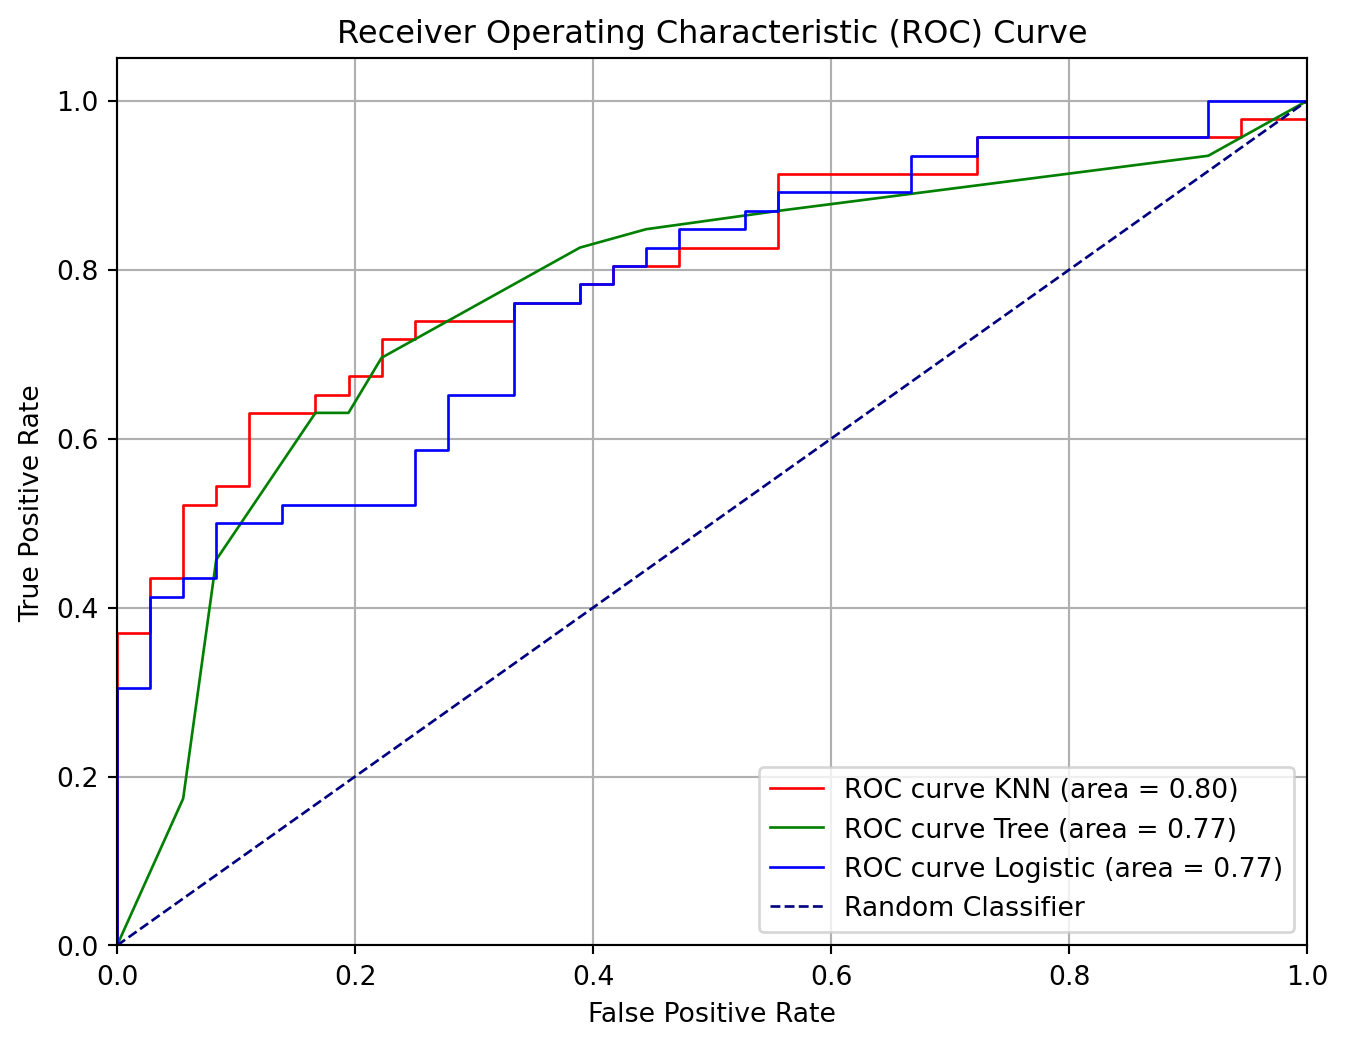

In [31]:
plt.figure(figsize = (8,6))
plt.plot(fpr_KNN, tpr_KNN, color='red', lw=1, label='ROC curve KNN (area = %0.2f)' % AUC_KNN)
plt.plot(fpr_Tree, tpr_Tree, color='green', lw=1, label='ROC curve Tree (area = %0.2f)' % AUC_Tree)
plt.plot(fpr_Log, tpr_Log, color='blue', lw=1, label='ROC curve Logistic (area = %0.2f)' % AUC_Log)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Part Two: Metrics

### Recall rates

#### KNN Model

In [32]:
y_train_KNN = pd.Series(Fit_Final_KNN.predict(X_train), name = "Predicted")

true_positives_KNN = ((y_train_KNN == 1) & (y_train == 1)).sum()

recall_KNN = true_positives_KNN / (y_train == 1).sum()

recall_KNN

np.float64(0.55)

#### Tree Model

In [33]:
y_train_tree = pd.Series(Fit_Final_tree.predict(X_train), name = "Predicted")

true_positives_tree = ((y_train_tree == 1) & (y_train == 1)).sum()

recall_tree = true_positives_tree / (y_train == 1).sum()

recall_tree

np.float64(0.43)

#### Logistic Model

In [34]:
y_train_log = pd.Series(Fit_Final_log.predict(X_train), name = "Predicted")

true_positives_log = ((y_train_log == 1) & (y_train == 1)).sum()

recall_log = true_positives_log / (y_train == 1).sum()

recall_log

np.float64(0.53)

### Precision 

#### KNN Model

In [35]:
precision_KNN = true_positives_KNN / (y_train_KNN == 1).sum()

precision_KNN

np.float64(0.55)

#### Tree Model

In [36]:
precision_Tree = true_positives_tree / (y_train_tree == 1).sum()

precision_Tree

np.float64(0.5180722891566265)

#### Logistic Model

In [37]:
precision_Log = true_positives_log / (y_train_log == 1).sum()

precision_Log

np.float64(0.5047619047619047)

### True Negative Rate

#### KNN Model

In [38]:
true_negatives_KNN = ((y_train_KNN == 0) & (y_train == 0)).sum()

Specificityu_KNN = true_negatives_KNN / (y_train_KNN == 0).sum()
Specificityu_KNN

np.float64(0.21978021978021978)

#### Tree Model

In [39]:
true_negatives_Tree = ((y_train_tree == 0) & (y_train == 0)).sum()

Specificityu_Tree = true_negatives_Tree / (y_train_tree == 0).sum()
Specificityu_Tree

np.float64(0.21296296296296297)

#### Logistic Model

In [40]:
true_negatives_log = ((y_train_log == 0) & (y_train == 0)).sum()

Specificityu_Log = true_negatives_log / (y_train_log == 0).sum()
Specificityu_Log

np.float64(0.1744186046511628)

## Part Three: Discussion

### Q1

The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack

Q: Which metric(s) you would use for model selection and why.

A: For the metrics we want to use the model with the highest precision as this shows the total true values that are what they were predicted to be, this ensures that we maintain the lowest amount of results that are later tured true. 

Q: Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

A: The KNN Model performed the best for the precision metric which further justifies are use of it moving forward in predictions. 

Q: What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

A: the score the we should expect is around .55

### Q2

The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

Q: Which metric(s) you would use for model selection and why.

A: The metric that most makes sense in this case is True Negative rate as we can justify sending these matients home as theur are not at risk of the heart attack and this is likely to remain that way and not change with the metric

Q: Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

A: The Final KNN Model would be most useful as this model had the best specificity score of all the three models.

Q: What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

A: We believe this model will have an outcome of around .22 specificity score 

### Q3

The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

Q: Which metric(s) you would use for model selection and why.

A: The metric we are intrested in here is the true positive rate as this mertirc helps us see what are the variables that are associated with heart attack and to what degree are in relation to true positives 

Q: Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

A: The KNN Model would be best for this scenerio as it perfromed the best in our choosen metric and also has the most importane when we testing the models varaible importance so we can see some true causality using the model. 

Q: What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

A: The Recall score expected using this model should be around 0.55

### Q4

The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

Q: Which metric(s) you would use for model selection and why.

A: The Metric to use for this scenerio would be precission as this tell how close predictions are to reality and gives doctors a good way to measure the models 

Q: Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

A: The KNN Model again had the best precision score and should be used for predicitive analysis for comparing accuracy of diagonoses

Q: What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

A: Based on the model we should expect a score of around .55

## Part Four: Validation

In [41]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

pt4_X = ha_validation.drop("output", axis=1)
pt4_y = ha_validation["output"]

### KNN Model

In [42]:
val_KNN_pred = Fit_Final_KNN.predict(pt4_X)

print("roc auc score for this model is " + str(roc_auc_score(pt4_y, val_KNN_pred)))
print(classification_report(pt4_y, val_KNN_pred))

roc auc score for this model is 0.7894736842105263
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        11
           1       1.00      0.58      0.73        19

    accuracy                           0.73        30
   macro avg       0.79      0.79      0.73        30
weighted avg       0.85      0.73      0.73        30



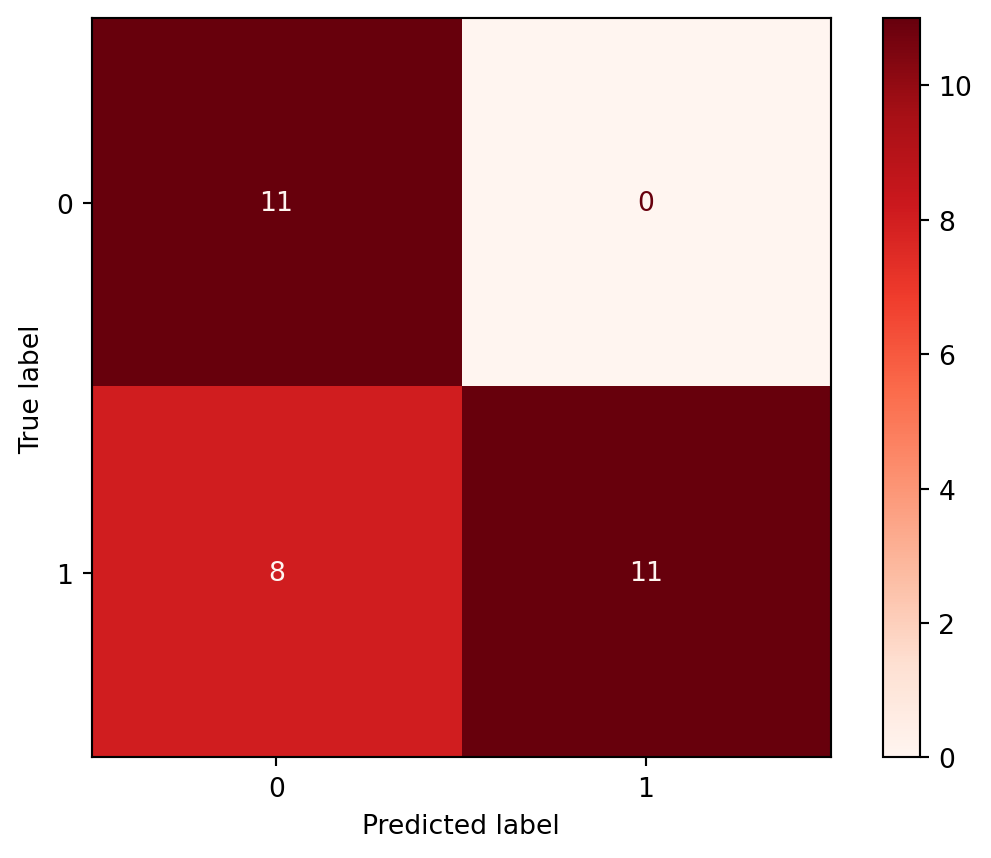

In [43]:
val_cm_knn = confusion_matrix(pt4_y, val_KNN_pred, labels=labels_KNN)

ConfusionMatrixDisplay(val_cm_knn).plot(cmap="Reds",  values_format="d")

### Tree Model

In [44]:
val_Tree_pred = Fit_Final_tree.predict(pt4_X)

print("roc auc score for this model is " + str(roc_auc_score(pt4_y, val_Tree_pred)))
print(classification_report(pt4_y, val_Tree_pred))

roc auc score for this model is 0.6459330143540669
              precision    recall  f1-score   support

           0       0.47      0.82      0.60        11
           1       0.82      0.47      0.60        19

    accuracy                           0.60        30
   macro avg       0.65      0.65      0.60        30
weighted avg       0.69      0.60      0.60        30



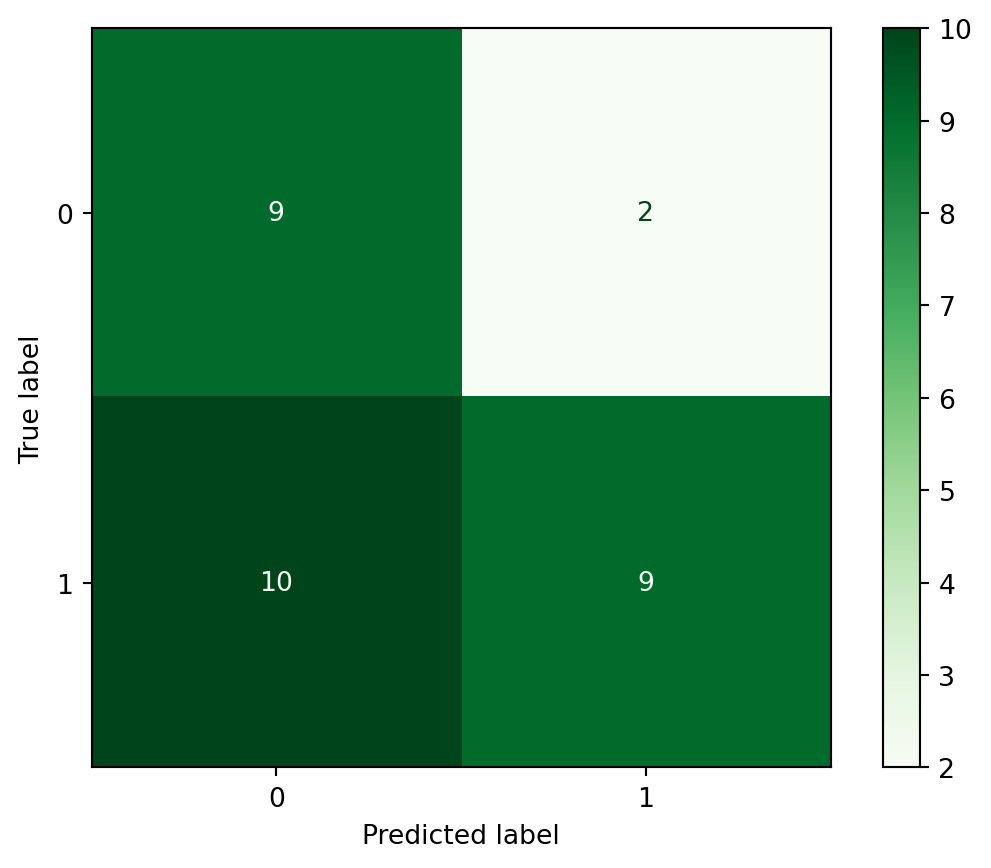

In [45]:
val_cm_tree = confusion_matrix(pt4_y, val_Tree_pred, labels=labels_tree)

ConfusionMatrixDisplay(val_cm_tree).plot(cmap="Greens",  values_format="d")

### Logistic Model

In [46]:
val_Log_pred = Fit_Final_log.predict(pt4_X)

print("roc auc score for this model is " + str(roc_auc_score(pt4_y, val_Log_pred)))
print(classification_report(pt4_y, val_Log_pred))

roc auc score for this model is 0.777511961722488
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.88      0.74      0.80        19

    accuracy                           0.77        30
   macro avg       0.76      0.78      0.76        30
weighted avg       0.79      0.77      0.77        30



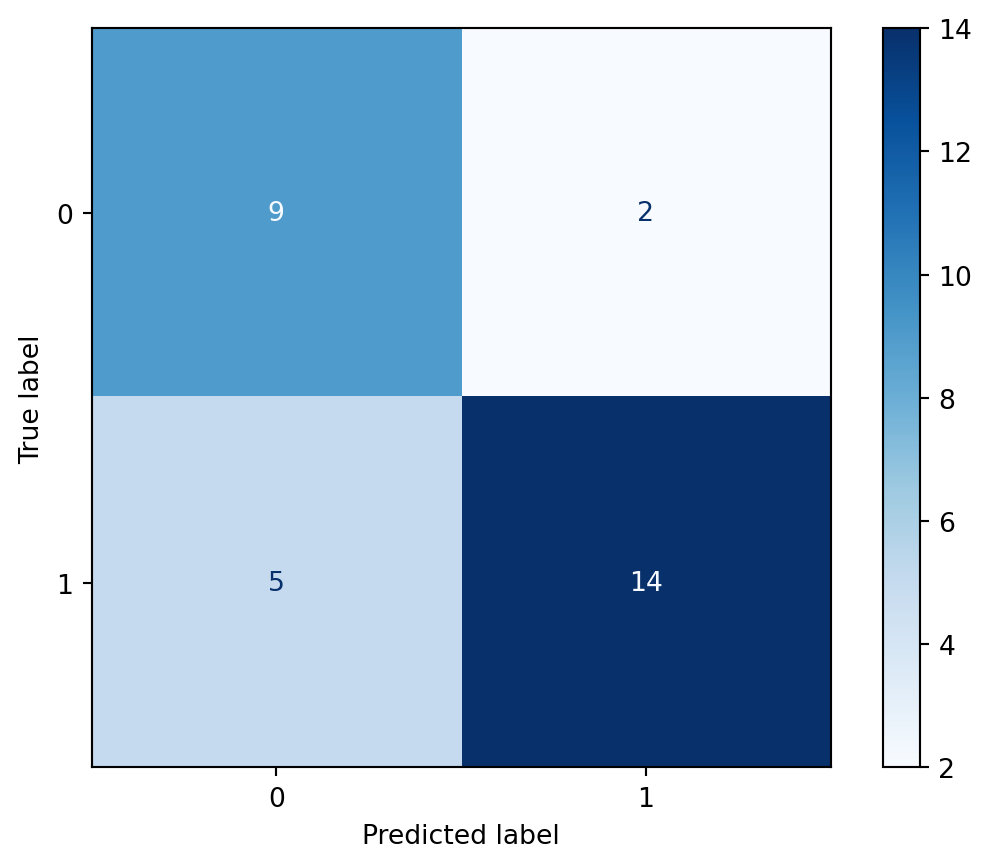

In [47]:
val_cm_log = confusion_matrix(pt4_y, val_Log_pred, labels=labels_log)

ConfusionMatrixDisplay(val_cm_log).plot(cmap="Blues",  values_format="d")

Analysis:

The original measure were slightly higher compared to the validation set, although also all of the auc roc score were roughly in the same predicited range. The Recall rates and Precision Rates were all lower predicted compared to the validation sets weighted avgs. Overall each models success is fairly accurate compared to the origninal fitting and tuning that we did. 

## Part Five: Cohen's Kappa 

### KNN Model

In [48]:
cohen_kappa_score(pred_final_KNN, y_test)

np.float64(0.4712778429073857)

### Tree Model

In [49]:
cohen_kappa_score(pred_final_tree, y_test)

np.float64(0.42321219226260254)

### Logistic Model

In [50]:
cohen_kappa_score(pred_final_log, y_test)

np.float64(0.34535777646363097)

Based on the Cohens Kappa Results it appears that our validations overestimated the models accuracy as the cohens kappa scores indicate that their is some agreement with our modeles prediction and the test data. showing that again the KNN model outperforms the other models with Cohens Kappa Score of .47 incidcating the chances of the two predictions agreeing on the result. This method makes the most sense to me and displays the flaws in our models while also showing that their will still be a fair amout of accuracy. 